In [2]:
import emcee
import copy
import radvel
import george
import corner
import numpy as np
import pandas as pd
import astropy.io.fits as fits
import matplotlib.pyplot as plt

from scipy import optimize
from george import kernels
from george.modeling import Model
from scipy.optimize import minimize
from radvel.plot import orbit_plots
from astropy.timeseries import LombScargle

### Import Data

In [6]:
# import datasets
pre_df = pd.read_csv('../datasets/ESPRESSO/espresso_pre.csv') # pre ESPRESSO
post_df = pd.read_csv('../datasets/ESPRESSO/espresso_post.csv') # post ESPRESSO
harps_df = pd.read_csv('../datasets/HARPS/harps.csv')      # HARPS

# process data
harps_df['Inst'] = 'HARPS'

pre_df = pre_df[['Time', 'RV', 'e_RV', 'Inst']]
post_df = post_df[['Time', 'RV', 'e_RV', 'Inst']]
#harps_df = harps_df[['Time', 'RV', 'e_RV', 'Inst']]

# combine datasets
df = pd.concat([pre_df, post_df], ignore_index=True)


Text(0, 0.5, 'RV')

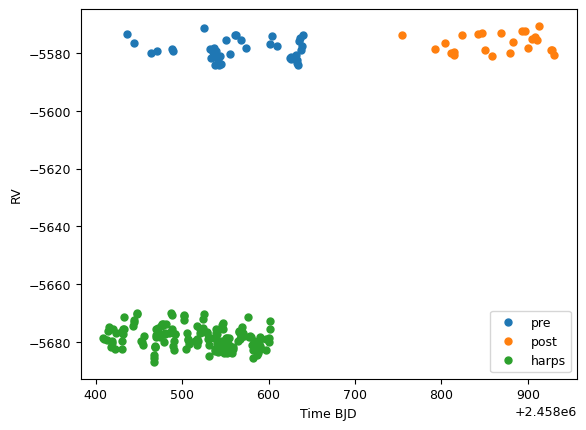

In [7]:
# quick bisualisation
plt.plot(pre_df['Time'], pre_df['RV'], 'o', label='pre')
plt.plot(post_df['Time'], post_df['RV'], 'o', label='post')
plt.plot(harps_df['Time'], harps_df['RV'], 'o', label='harps')
plt.legend()
plt.xlabel('Time BJD')
plt.ylabel('RV')

In [8]:
df.head()

,Time,RV,e_RV,Inst
0,2.458437e+06,-5573.437416,0.816913,Pre
1,2.458445e+06,-5576.693982,0.793815,Pre
2,2.458464e+06,-5580.193552,0.653161,Pre
3,2.458471e+06,-5579.244790,0.676495,Pre
4,2.458489e+06,-5578.568851,1.060688,Pre


###  PP

In [9]:
df

,Time,RV,e_RV,Inst
0,2.458437e+06,-5573.437416,0.816913,Pre
1,2.458445e+06,-5576.693982,0.793815,Pre
2,2.458464e+06,-5580.193552,0.653161,Pre
3,2.458471e+06,-5579.244790,0.676495,Pre
4,2.458489e+06,-5578.568851,1.060688,Pre
...,...,...,...,...
58,2.458911e+06,-5575.435627,0.574009,Post
59,2.458913e+06,-5570.733418,0.740746,Post
60,2.458927e+06,-5579.203590,0.721367,Post
61,2.458928e+06,-5579.119681,0.673235,Post


In [10]:
def initialise_model():
    time_base = 0
    params = radvel.Parameters(num_planets=3, basis='per tc secosw sesinw k')

    # planet b
    params['per1'] = radvel.Parameter(value=2.25)
    params['tc1'] = radvel.Parameter(value=1366.17)
    params['secosw1'] = radvel.Parameter(value=-0.027)
    params['sesinw1'] = radvel.Parameter(value=-0.028)
    params['k1'] = radvel.Parameter(value=0.46)

    # planet c
    params['per2'] = radvel.Parameter(value=3.69)
    params['tc2'] = radvel.Parameter(value=1367.27)
    params['secosw2'] = radvel.Parameter(value=-0.14)
    params['sesinw2'] = radvel.Parameter(value=-0.099)
    params['k2'] = radvel.Parameter(value=2.19)

    # planet d
    params['per3'] = radvel.Parameter(value=7.45)
    params['tc3'] = radvel.Parameter(value=1362.74)
    params['secosw3'] = radvel.Parameter(value=-0.062)
    params['sesinw3'] = radvel.Parameter(value=0)
    params['k3'] = radvel.Parameter(value=1.50)

    # instrument jitter parameters
    params['dvdt'] = radvel.Parameter(value=0)
    params['curv'] = radvel.Parameter(value=0)
    
    mod = radvel.RVModel(params, time_base=time_base)
    return mod

In [11]:
def initialise_likelihood(rv, suffix):
    like = radvel.likelihood.RVLikelihood(
        mod, rv.Time, rv.RV, rv.e_RV, suffix=suffix)
    return like
mod = initialise_model()

# HARPS data
like_harps = initialise_likelihood(harps_df, 'HARPS')
like_harps.params['gammaHARPS'].value = 1.0 
like_harps.params['gammaHARPS'].vary = False 

# ESPRESSO data
like_pre = initialise_likelihood(pre_df, 'pre')
like_pre.params['gammapre'].value = 1.0
like_pre.params['gammapre'].vary = False

like_post = initialise_likelihood(post_df, 'post')
like_post.params['gammapost'].value = 1.0
like_post.params['gammapost'].vary = False

# combine likelihoods
like = radvel.likelihood.CompositeLikelihood(
    [like_harps, like_pre, like_post])

# initial values for jitter
like.params['jitHARPS'].value = np.log(2.6)
like.params['jitpre'].value = np.log(2.6)
like.params['jitpost'].value = np.log(2.6)

like.params['dvdt'].vary = False
like.params['curv'].vary = False
like.params['jitHARPS'].vary = False
like.params['jitpre'].vary = False
like.params['jitpost'].vary = False

In [12]:
print(like_harps.params)
print(like_pre.params)
print(like_post.params)

Parameters([('per1', Parameter object: value = 2.25, vary = True, mcmc scale = None), ('tc1', Parameter object: value = 1366.17, vary = True, mcmc scale = None), ('secosw1', Parameter object: value = -0.027, vary = True, mcmc scale = None), ('sesinw1', Parameter object: value = -0.028, vary = True, mcmc scale = None), ('k1', Parameter object: value = 0.46, vary = True, mcmc scale = None), ('per2', Parameter object: value = 3.69, vary = True, mcmc scale = None), ('tc2', Parameter object: value = 1367.27, vary = True, mcmc scale = None), ('secosw2', Parameter object: value = -0.14, vary = True, mcmc scale = None), ('sesinw2', Parameter object: value = -0.099, vary = True, mcmc scale = None), ('k2', Parameter object: value = 2.19, vary = True, mcmc scale = None), ('per3', Parameter object: value = 7.45, vary = True, mcmc scale = None), ('tc3', Parameter object: value = 1362.74, vary = True, mcmc scale = None), ('secosw3', Parameter object: value = -0.062, vary = True, mcmc scale = None), 

In [13]:
# Instantiate posterior
post = radvel.posterior.Posterior(like)
post0 = copy.deepcopy(post)

# Add in priors
post.priors += [radvel.prior.EccentricityPrior( 3 )] # Keeps eccentricity < 1

# Perform Max-likelihood fitting
res  = optimize.minimize(
    post.neglogprob_array,
    post.get_vary_params(), 
    method='Powell',
    options=dict(maxiter=100000,maxfev=100000,xtol=1e-8)
    )

print("Initial loglikelihood = %f" % post0.logprob())
print("Final loglikelihood = %f" % post.logprob())
print(post)

Initial loglikelihood = -1168898500.654096
Final loglikelihood = -923440550.831098
parameter                     value      vary
per1                         1.2882       True
tc1                         1366.18       True
secosw1                   -0.444774       True
sesinw1                   -0.532476       True
k1                          2182.11       True
per2                        3.46392       True
tc2                         1367.39       True
secosw2                    -0.59314       True
sesinw2                    0.676723       True
k2                          2170.42       True
per3                         8.4472       True
tc3                         1362.45       True
secosw3                    0.548111       True
sesinw3                   -0.804128       True
k3                          9040.45       True
dvdt                              0      False
curv                              0      False
gammaHARPS                        1      False
jitHARPS                 

In [14]:
df = radvel.mcmc(post, nrun=200, savename='rawchains.h5')

20000/80000 (25.0%) steps complete; Running 4997.05 steps/s; Mean acceptance rate = 10.3%; Min Auto Factor =  15; Max Auto Relative-Change =   inf; Min Tz = 2736.8; Max G-R = 1.010
Discarding burn-in now that the chains are marginally well-mixed

80000/80000 (100.0%) steps complete; Running 5859.85 steps/s; Mean acceptance rate = 2.3%; Min Auto Factor =  14; Max Auto Relative-Change = 0.502; Min Tz = 2459.6; Max G-R = 1.012

MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


In [15]:
df_synth = post.params.basis.to_synth(df)
labels = 'per1 tc1 e1 k1 per2 tc2 e2 k2 per3 tc3 e3 k3'.split()
df_synth[labels].quantile([0.14,0.5,0.84]).T

,0.14,0.50,0.84
per1,1.288198,1.288198,1.288199
tc1,1366.173543,1366.228655,1366.279446
e1,0.398832,0.434955,0.468594
k1,2164.922706,2278.417116,2377.247962
per2,3.463918,3.463929,3.463937
tc2,1367.392982,1367.441924,1367.478764
e2,0.777205,0.825885,0.881491
k2,2149.105380,2271.267629,2373.181228
per3,8.447200,8.447230,8.447286
tc3,1362.446503,1362.500959,1362.541688


Pandas support in corner is deprecated; use ArviZ directly


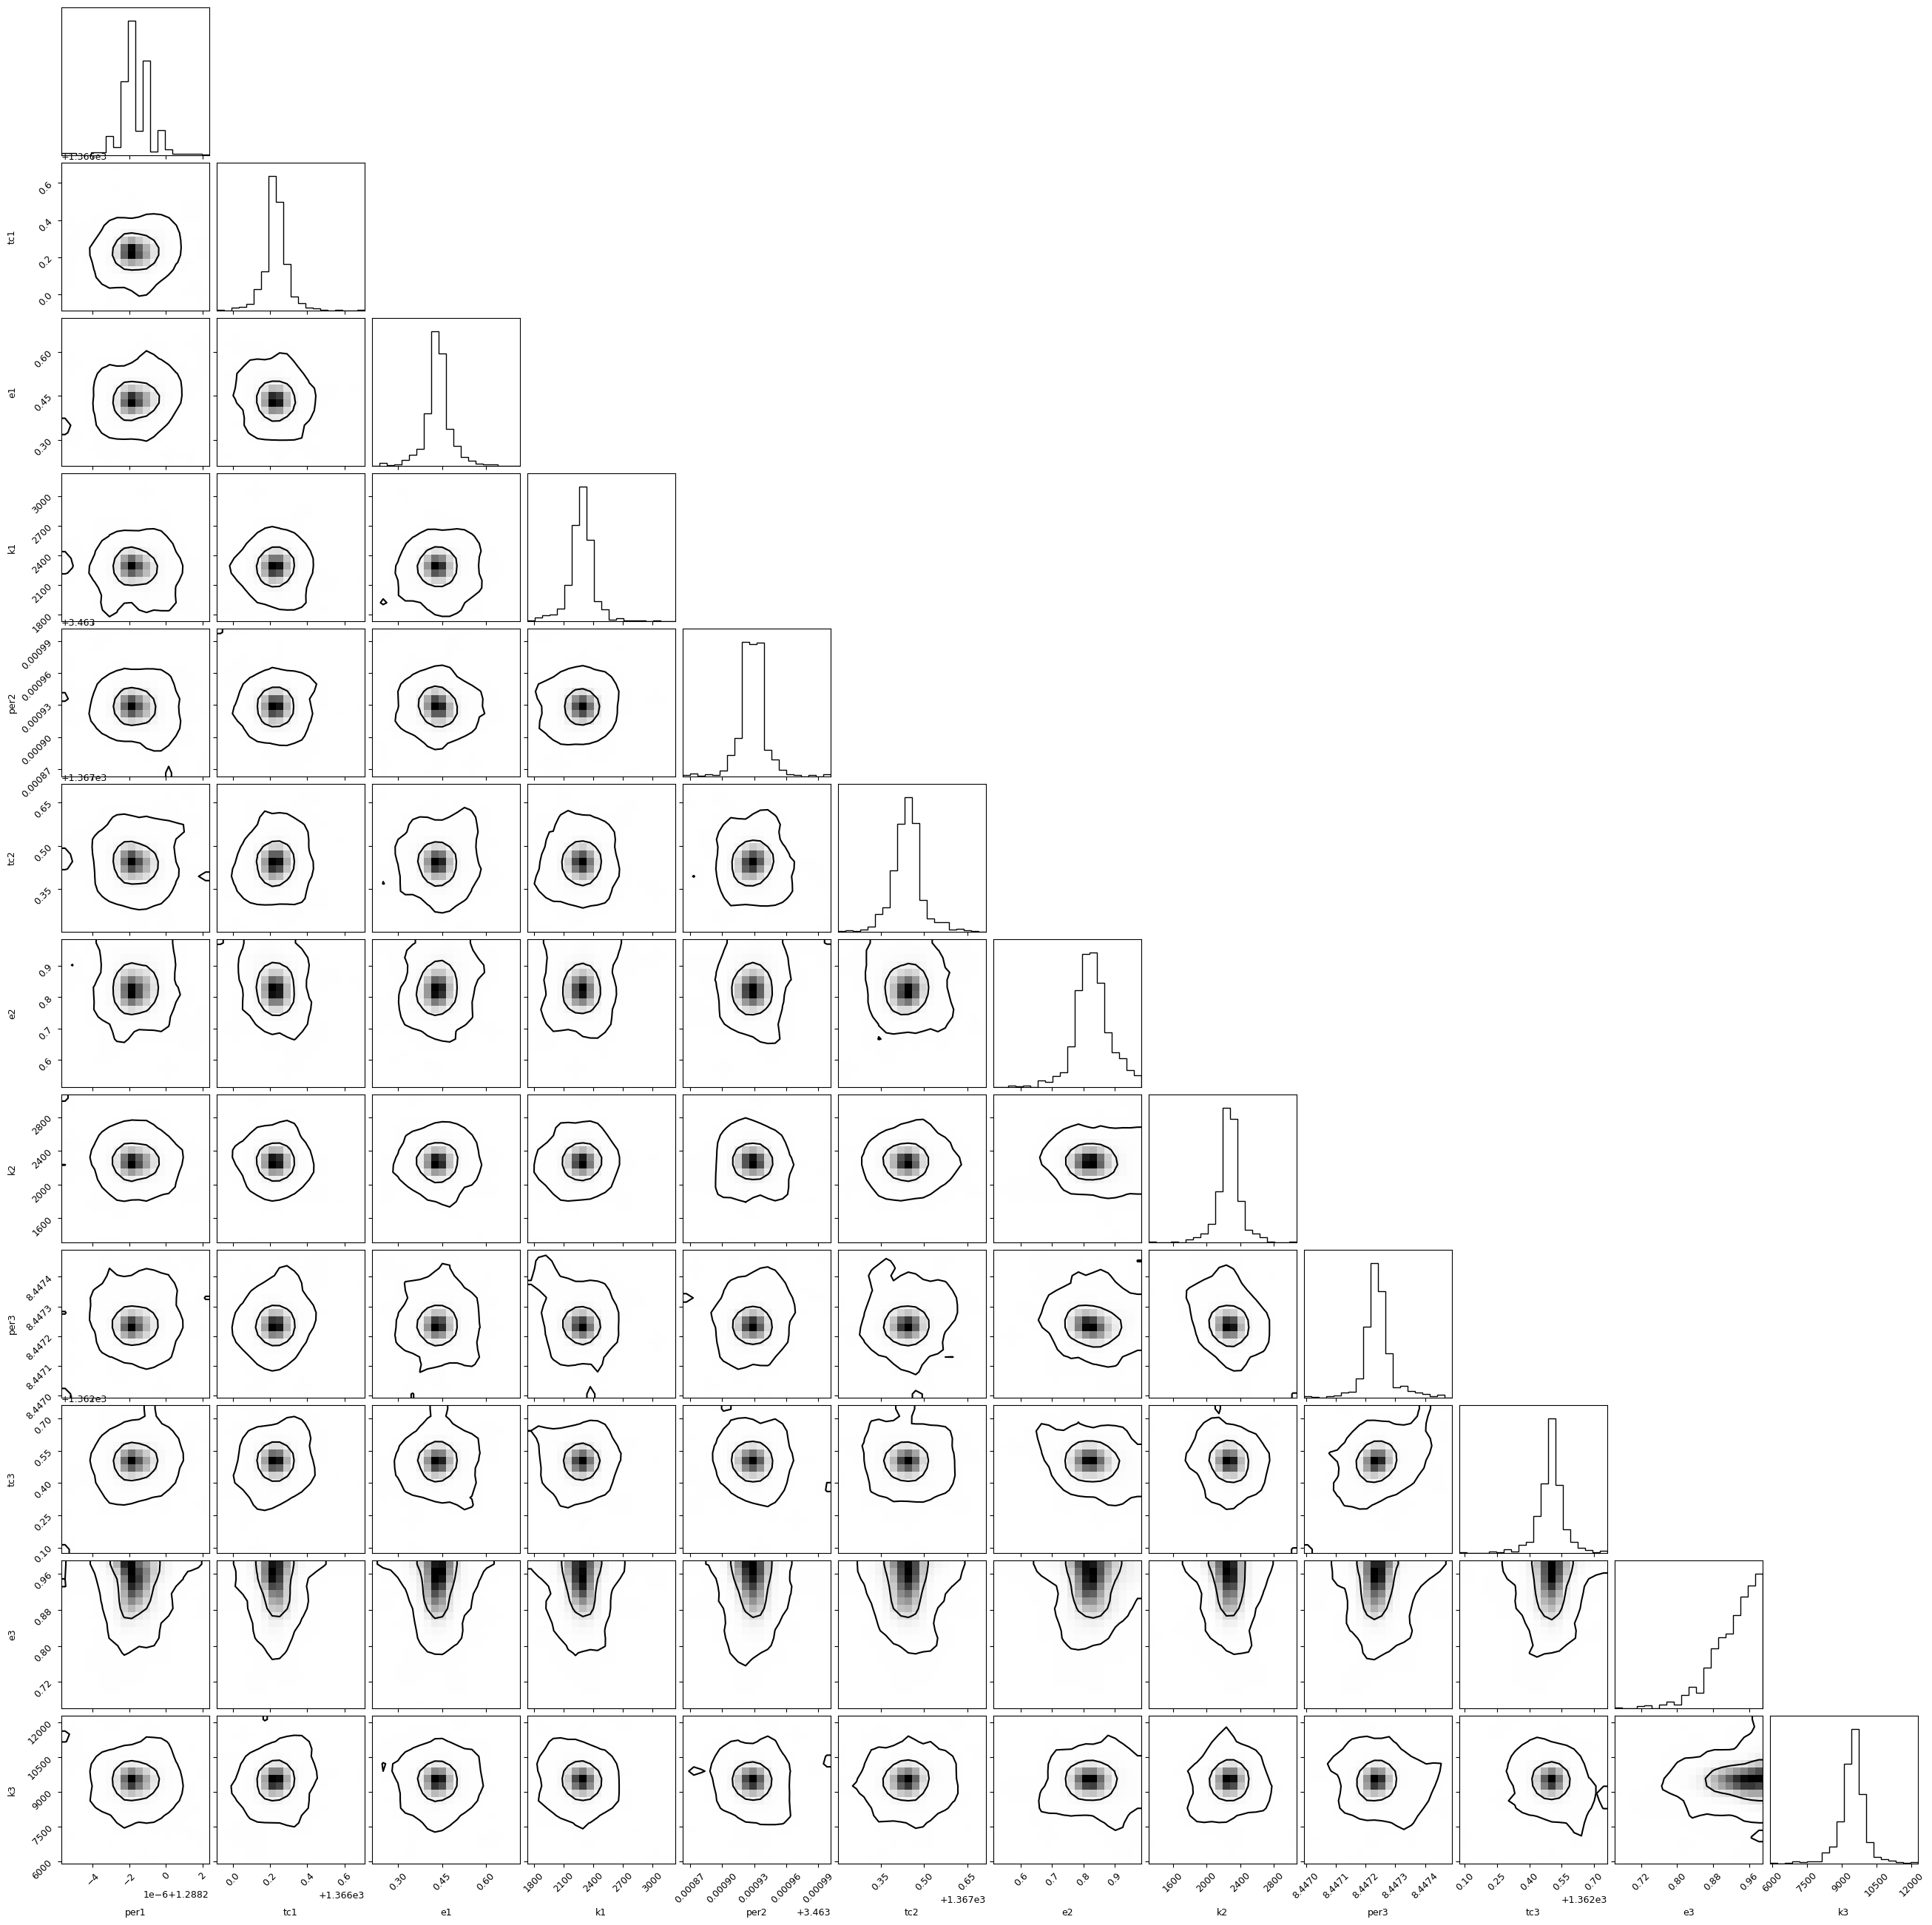

In [16]:
labels = 'per1 tc1 e1 k1 per2 tc2 e2 k2 per3 tc3 e3 k3'.split()

fig = corner.corner(
    df_synth[labels],labels=labels,
    levels=[0.68,0.95],plot_datapoints=False,smooth=True,bins=20
    )

(<Figure size 750x1414.29 with 6 Axes>,
 [<Axes: ylabel='RV [m s$^{\\mathregular{-1}}$]'>,
  <Axes: xlabel='JD - 2450000', ylabel='Residuals'>,
  <Axes: xlabel='Phase', ylabel='RV [m s$^{\\mathregular{-1}}$]'>,
  <Axes: xlabel='Phase', ylabel='RV [m s$^{\\mathregular{-1}}$]'>,
  <Axes: xlabel='Phase', ylabel='RV [m s$^{\\mathregular{-1}}$]'>])

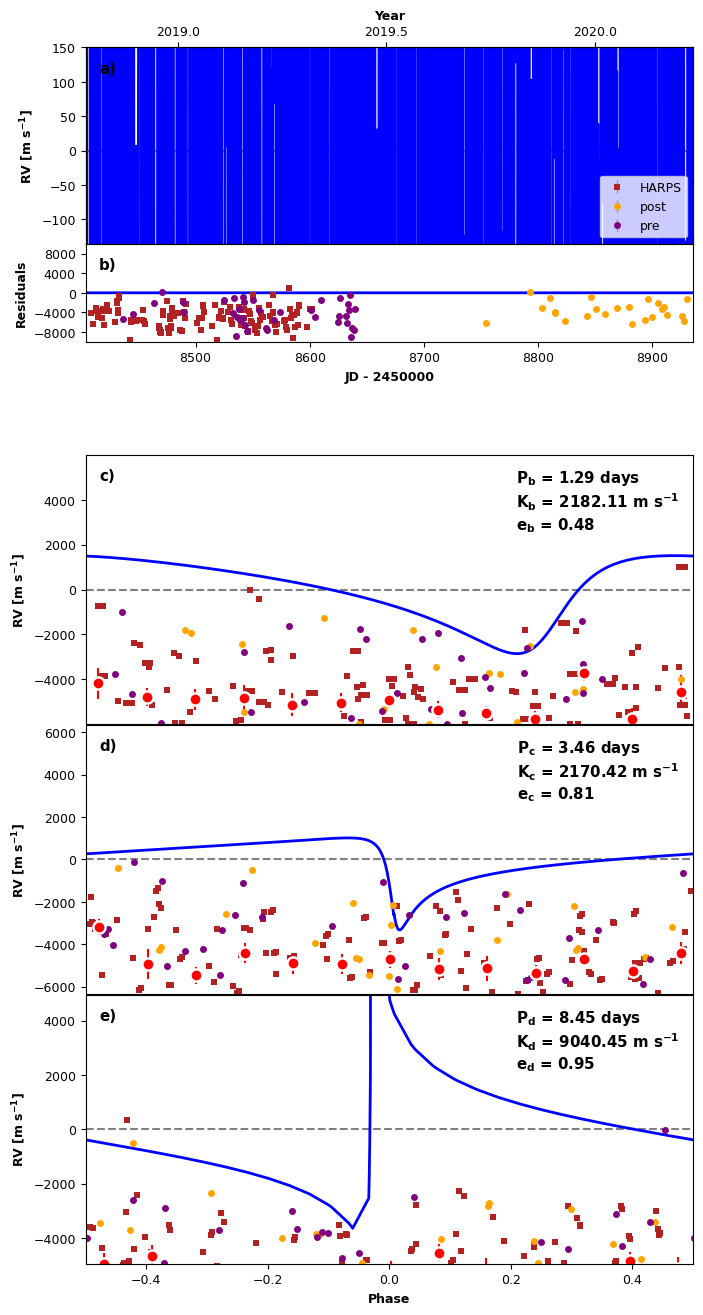

In [17]:
RVPlot = orbit_plots.MultipanelPlot(post)
RVPlot.plot_multipanel()